In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import imutils
from imutils.object_detection import non_max_suppression

Visualizamos el template y las imagenes dadas. 

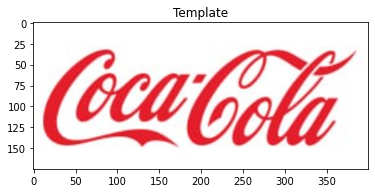

In [3]:
template = cv2.imread("pattern.png")
tH, tW = template.shape[:2]
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title('Template')
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template = cv2.Canny(template, 50, 200)

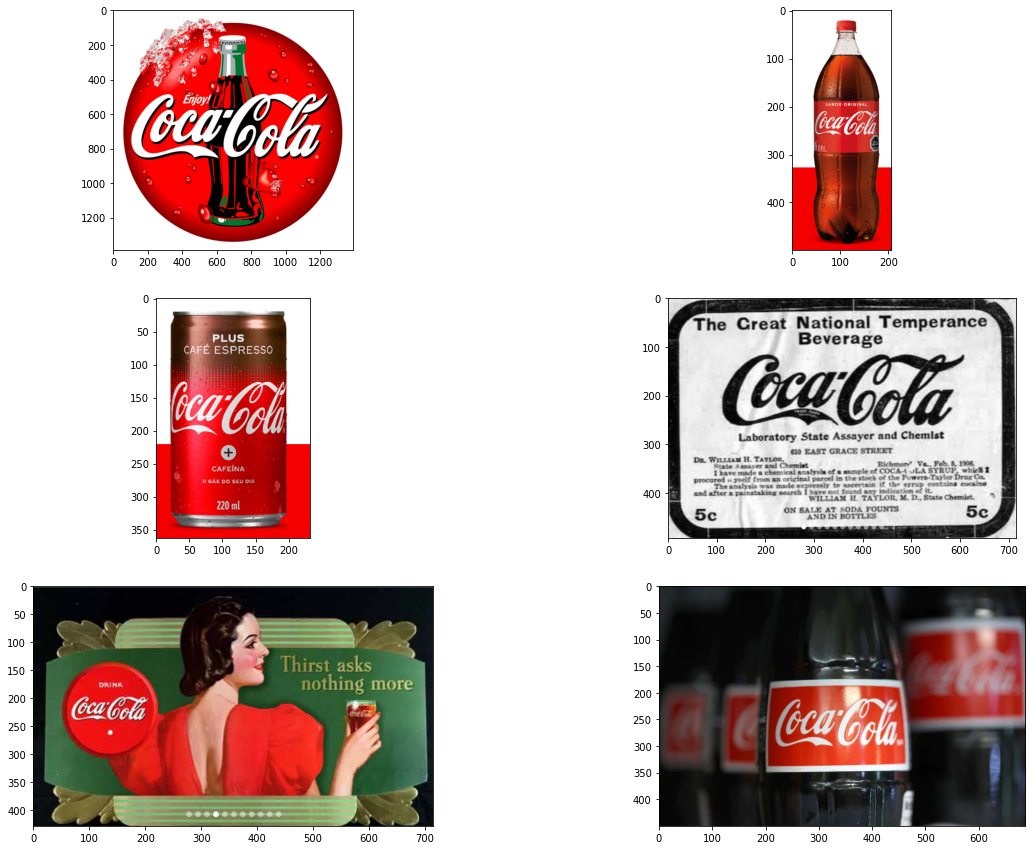

In [4]:
path='./img'
imgs = os.listdir(path)
idx=0
phs=[]
for foto in imgs:
      idx+=1
      ph=cv2.imread(os.path.join(path,foto))
      phs.append(ph)
plt.subplots(3, 2,figsize=(20,15))
for i in range(idx):
    plt.subplot(3,2,i+1)
    plt.imshow(cv2.cvtColor(phs[i], cv2.COLOR_BGR2RGB))

Podemos ver que en algunos casos el template queda mas grande o mas chico en las imagenes a detectar, por lo cual voy a optar por variar el tamaño de las mismas para obtener un match correcto con el template.

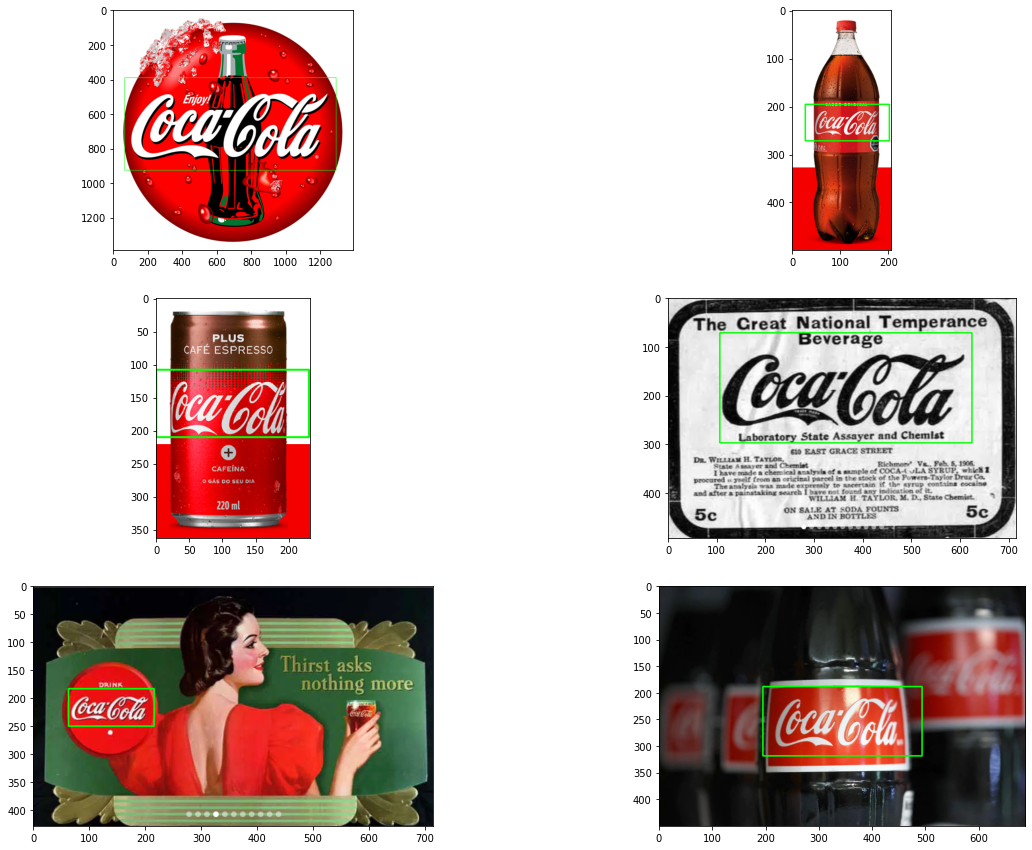

In [8]:
#leo imagenes a procesar
path='./img'
imgs = os.listdir(path)
ix=0
arrVal=[]
arrCoor=[]
rel=[]
imagenes=[]
for foto in imgs: 
      ph=cv2.imread(os.path.join(path,foto))
      gray = cv2.cvtColor(ph, cv2.COLOR_BGR2GRAY)
      ix+=1
      for dim in np.linspace(0.2, 3, 45)[::-1]: #voy cambiando el tamaño de la imagen leida
            res = imutils.resize(gray, width = int(gray.shape[1] * dim))
            if res.shape[0] < tH or res.shape[1] < tW:#dejamos de procesar si el tamaño de la imagen es menor al del template
               break
            r = gray.shape[1] / float(res.shape[1])  #relacion de la imagen original y su nuevo tamaño
            edged = cv2.Canny(res, 100, 200) 
            result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)  
            (_, val_max, _, coor_max) = cv2.minMaxLoc(result)
            arrVal.append(val_max)#guardo el valor maximo encontrado, su posicion y el valor de r 
            arrCoor.append(coor_max)
            rel.append(r)
      #de todos los valores de coincidencia que obtuvimos con los diferentes tamaños me quedo con el mayor para cada imagen y obtengo sus coordenadas
      max_value = max(arrVal)
      loc=arrVal.index(max_value)
      rnew=rel[loc]
      copy_=arrCoor[loc]
      # finalmente dibujo el bbox de la mejor coincidencia y guardo la imagen para luego visualizarlas
      (iX, iY) = (int(copy_[0] * rnew), int(copy_[1] * rnew))
      (eX, eY) = (int((copy_[0] + tW) * rnew), int((copy_[1] + tH) * rnew))
      cv2.rectangle(ph, (iX, iY), (eX, eY), (0, 255, 0), 2)
      imagenes.append(ph)
      arrVal=[]
      arrCoor=[]
      rel=[]   
     
fig, axs = plt.subplots(3, 2,figsize=(20,15))
for i in range(ix):
    plt.subplot(3,2,i+1)
    plt.imshow(cv2.cvtColor(imagenes[i], cv2.COLOR_BGR2RGB))
      

Podemos ver que en todas las imagenes obtuvimos una correcta deteccion pero a costa de mucho tiempo de procesamiento ya que para detectar el logo en todas las imagenes debimos cambiar el tamaño de cada una repetidas veces. 

Parte 2

En este caso voy a hacer un procedimiento similar pero solo agrandando la imagen ya que las etiquetas multiples son todas mas chicas y tienen todas mas o menos el mismo tamaño pero se obtienen mas detecciones variando de a pequeños pasos la dimension de la imagen. 

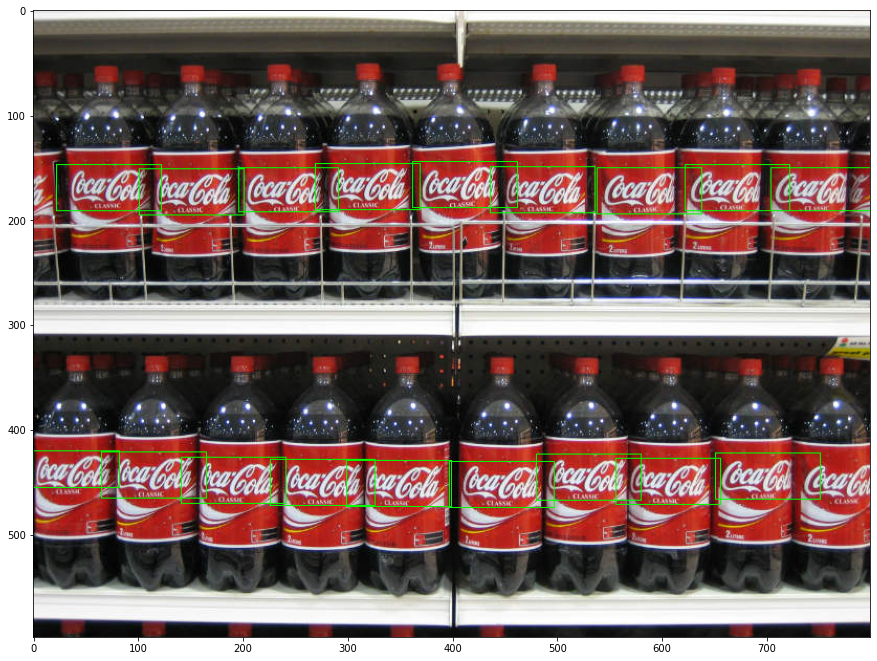

In [10]:
path='./multi'
imgs = os.listdir(path)
th=0.06
coord=[]
non_repeated = []
for foto in imgs:
      ph=cv2.imread(os.path.join(path,foto))
      gray = cv2.cvtColor(ph, cv2.COLOR_BGR2GRAY)
      for dim in np.linspace(4, 6,10)[::-1]:
            res = imutils.resize(gray, width = int(gray.shape[1] * dim))
            r = gray.shape[1] / float(res.shape[1])
            if res.shape[0] < tH or res.shape[1] < tW:
               break
            edged = cv2.Canny(res, 200, 255)
            result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF_NORMED)
            loc = np.where( result >= th)
            for pt in zip(*loc[::-1]):
                  coord.append((  int(pt[0]*r)  ,  int(pt[1]*r)  ,  int((pt[0] + tW)*r)  ,  int((pt[1] + tH)*r) )) 
            non_repeated = non_max_suppression(np.array(coord))

for (xb, yb, xe, ye) in non_repeated:
	cv2.rectangle(ph, (xb, yb), (xe, ye), (0, 255, 0), 1)
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(ph, cv2.COLOR_BGR2RGB))

Conclusiones: en la primer parte, al tener que detectar solo un logo por imagen pude aplicar la condicion de solo quedarme con el valor de resul mayor y descartar los otros. Pero en este caso eran varias etiquetas por lo tanto debia conservar varios resultados y eso me traia problemas de superposicion de cuadros ya que tambien voy variando el tamaño de la imagen para detectar mas etiquetas. Por lo tanto en la segunda parte utilice la funcion non_max_suppresion para solucionar este problema. 